# Imports and config variables

In [1]:
import pickle, math, shapefile, shapely, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ast import literal_eval
from collections import defaultdict
from tqdm import tqdm
from shapely.geometry import Polygon, Point
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [2]:
use_idf = True
max_features = 2**10
pca_components = 2**4
ngram_range = (1, 2)
min_df = 100
DATA_DIR = Path("/media/alex/Backup/Alex Yelp/csvs")

# Pre-defined methods

In [3]:
def generatePolygon(ctrX, ctrY, aveRadius, irregularity, spikeyness, numVerts):
    """Start with the centre of the polygon at ctrX, ctrY,
    then creates the polygon by sampling points on a circle around the centre.
    Randon noise is added by varying the angular spacing between sequential points,
    and by varying the radial distance of each point from the centre.

    Params:
    ctrX, ctrY - coordinates of the "centre" of the polygon
    aveRadius - in px, the average radius of this polygon, this roughly controls how large the polygon is, really only useful for order of magnitude.
    irregularity - [0,1] indicating how much variance there is in the angular spacing of vertices. [0,1] will map to [0, 2pi/numberOfVerts]
    spikeyness - [0,1] indicating how much variance there is in each vertex from the circle of radius aveRadius. [0,1] will map to [0, aveRadius]
    numVerts - self-explanatory

    Returns a list of vertices, in CCW order.
    """

    irregularity = clip(irregularity, 0, 1) * 2 * math.pi / numVerts
    spikeyness = clip(spikeyness, 0, 1) * aveRadius

    # generate n angle steps
    angleSteps = []
    lower = (2 * math.pi / numVerts) - irregularity
    upper = (2 * math.pi / numVerts) + irregularity
    sum = 0
    for i in range(numVerts):
        tmp = random.uniform(lower, upper)
        angleSteps.append(tmp)
        sum = sum + tmp

    # normalize the steps so that point 0 and point n+1 are the same
    k = sum / (2 * math.pi)
    for i in range(numVerts):
        angleSteps[i] = angleSteps[i] / k

    # now generate the points
    points = []
    angle = random.uniform(0, 2 * math.pi)
    for i in range(numVerts):
        r_i = clip(random.gauss(aveRadius, spikeyness), 0, 2 * aveRadius)
        x = ctrX + r_i * math.cos(angle)
        y = ctrY + r_i * math.sin(angle)
        points.append((int(x), int(y)))

        angle = angle + angleSteps[i]

    return points


def clip(x, min, max):
    if min > max:
        return x
    elif x < min:
        return min
    elif x > max:
        return max
    else:
        return x

# Build business count vectors

In [4]:
bf_text = pd.read_csv(Path.joinpath(DATA_DIR, "business_text_stripped.csv"))
uf_text = pd.read_csv(Path.joinpath(DATA_DIR, "user_text_stripped.csv"))

In [6]:
bf_text.columns

Index(['Unnamed: 0', 'business', 'text'], dtype='object')

In [7]:
alldocs = list(bf_text["text"].values) + list(uf_text["text"].values)
busids = list(bf_text["business"].values)
vectorizer = CountVectorizer(
    strip_accents="ascii",
    stop_words="english",
    ngram_range=ngram_range,
    min_df=min_df,
    max_features=max_features,
)

Xo = vectorizer.fit_transform(alldocs)
words = vectorizer.get_feature_names()

if use_idf:
    transformer = TfidfTransformer(use_idf=True)
    Xo = transformer.fit_transform(Xo)

# Build per-neighbourhood count vectors

In [8]:
bf = pd.read_csv(Path.joinpath(DATA_DIR, "businesses.csv"))
sf = shapefile.Reader(
    "/home/alex/uem_projects/neighbourhoods_wgs84/NEIGHBORHOODS_WGS84"
)
d = {}
for shape in sf.iterShapeRecords():
    d[shape.record.AREA_NAME] = Polygon(shape.shape.points)

n2bid = defaultdict(list)

for bid, loc in tqdm(bf[["id", "coordinates"]].values):
    loc = literal_eval(loc)
    if loc["longitude"] is not None and loc["latitude"] is not None:
        p = Point(loc["longitude"], loc["latitude"])
        for k, v in d.items():
            if v.contains(p):
                n2bid[k].append(bid)

neighbourhoodcounts = {}
for k, v in tqdm(n2bid.items(), total=len(n2bid.keys())):
    total = np.zeros((Xo.shape[1],))
    for bid in v:
        if bid in busids:
            total += Xo[busids.index(bid), :]
    neighbourhoodcounts[k] = np.asarray(total)[0]

/home/alex/anaconda3/envs/embed/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
100%|██████████| 140/140 [00:10<00:00, 13.94it/s]


# Build fake neighbourhood count vectors

In [9]:
def get_max_sim(real, fake):
    sims = []
    for k, v in fake.items():
        maxsim = 0
        for l, w in real.items():
            s = np.linalg.norm(v - w)
            if s > maxsim:
                maxsim = s
        sims.append(maxsim)
    return sims

In [10]:
sf = shapefile.Reader(
    "/home/alex/uem_projects/neighbourhoods_wgs84/NEIGHBORHOODS_WGS84"
)

d = {}

for shape in sf.iterShapeRecords():
    d[shape.record.AREA_NAME] = Polygon(shape.shape.points)

allcoords = []
for cdict in bf.coordinates.values:
    cdict = literal_eval(cdict)
    if cdict["longitude"] is not None and cdict["latitude"] is not None:
        allcoords.append((cdict["longitude"], cdict["latitude"]))

areas = []
for t in d.values():
    areas.append(t.area)

mu = np.mean(areas)
si = np.std(areas)

factor = 1e9
similarity = 0
fakes = []
for i in range(150):
    coord = random.choice(allcoords)
    fakes.append(
        generatePolygon(
            ctrX=coord[0] * factor,
            ctrY=coord[1] * factor,
            aveRadius=random.gauss(mu, si) * factor,
            irregularity=random.uniform(0, 1),
            spikeyness=random.uniform(0, 0.5),
            numVerts=random.randint(3, 50),
        )
    )

for i, fake in enumerate(fakes):
    for j, points in enumerate(fake):
        fake[j] = (points[0] / factor, points[1] / factor)
    fakes[i] = fake

polygon_fakes = [Polygon(fake) for fake in fakes]

n2bid_fakes = defaultdict(list)
for bid, loc in tqdm(bf[["id", "coordinates"]].values):
    loc = literal_eval(loc)
    if loc["longitude"] is not None and loc["latitude"] is not None:
        p = Point(loc["longitude"], loc["latitude"])
        for k, v in enumerate(polygon_fakes):
            if v.contains(p):
                n2bid_fakes[k].append(bid)

neighbourhoodcounts_fakes = {}
for k, v in tqdm(n2bid_fakes.items(), total=len(n2bid_fakes.keys())):
    total = np.zeros((Xo.shape[1],))
    for bid in v:
        if bid in busids:
            total += Xo[busids.index(bid), :]
    neighbourhoodcounts_fakes[k] = np.asarray(total)[0]

for k, v in neighbourhoodcounts.items():
    if np.sum(v) != 0:
        neighbourhoodcounts[k] /= np.sum(v)

for k, v in neighbourhoodcounts_fakes.items():
    if np.sum(v) != 0:
        neighbourhoodcounts_fakes[k] /= np.sum(v)

100%|██████████| 144/144 [00:00<00:00, 222.91it/s]


# Normalise count vectors and run PCA

In [11]:
names = list(neighbourhoodcounts.keys())
vals = np.asarray(list(neighbourhoodcounts.values()))
names_fakes = list(neighbourhoodcounts_fakes.keys())
vals_fakes = np.asarray(list(neighbourhoodcounts_fakes.values()))

In [54]:
display(vals[0])
display(vals_fakes[0])

array([0.00077523, 0.00220934, 0.00042077, ..., 0.000455  , 0.00023546,
       0.00037168])

array([0.00060502, 0.00248098, 0.00040897, ..., 0.00038005, 0.00014103,
       0.00059112])

In [12]:
Xo = np.vstack([Xo.toarray(), vals])

In [13]:
from copy import deepcopy

Xo_norm = deepcopy(Xo)
for i in range(Xo_norm.shape[0]):
    Xot = Xo_norm[i, :].sum()
    if Xot != 0:
        Xo_norm[i, :] /= Xot

In [14]:
pca = PCA(n_components=pca_components)

pca.fit(Xo_norm)

X = pca.transform(vals)
Xf = pca.transform(vals_fakes)


def train_test_clf(X_real, X_fake, random_labels=False):
    X_all = np.vstack([X_real, X_fake])
    y_all = np.zeros((X_all.shape[0],))
    y_all[140:] = 1
    results = []
    for i in tqdm(range(1000)):
        if random_labels:
            y_all = np.asarray([randint(0, 1) for i in range(y_all.shape[0])])
        X_train, X_test, y_train, y_test = train_test_split(
            X_all, y_all, test_size=0.33, shuffle=True
        )
        clf = SVC(gamma="scale")
        clf.fit(X_train, y_train)
        results.append(clf.score(X_test, y_test))

    return np.mean(results), clf


out_full, _ = train_test_clf(vals, vals_fakes)
out_quick, _ = train_test_clf(X, Xf)

100%|██████████| 1000/1000 [00:02<00:00, 470.81it/s]


In [15]:
print(out_full)

0.46747872340425534


In [16]:
print(out_quick)

0.46767021276595744


# Autoencoder

In [20]:
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


In [21]:
input_vec = Input(shape=(Xo_norm.shape[1],))
encoded = Dense(2**10, activation="relu")(input_vec)
encoded = Dense(2**8, activation="relu")(encoded)
encoded = Dense(pca_components, activation="relu")(encoded)

decoded = Dense(2**8, activation="relu")(encoded)
decoded = Dense(2**10, activation="relu")(decoded)
decoded = Dense(Xo.shape[1], activation="sigmoid")(decoded)
autoencoder = Model(input_vec, decoded)

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
encoder = Model(input_vec, encoded)

In [23]:
autoencoder.compile(optimizer="adam", loss="cosine_proximity")

In [48]:
# tfs_sum = np.reshape(Xo_norm.sum(axis=1),(Xo_norm.shape[0],1))

# tfs = Xo_norm / np.repeat(tfs_sum,1024,axis=1)

# tfs[tfs != tfs] = 0

Xo_norm[Xo_norm != Xo_norm] = 0
tfs = Xo_norm

In [52]:
Xo_norm.shape

(159688, 1024)

In [49]:
X_train, X_test, _, _ = train_test_split(tfs, np.zeros((tfs.shape[0],)), test_size=0.05)

autoencoder.fit(
    X_train,
    X_train,
    epochs=300,
    batch_size=152419 // 100,
    shuffle=True,
    validation_data=(X_test, X_test),
)

X_real = encoder.predict(vals)
X_fake = encoder.predict(vals_fakes)

Train on 151703 samples, validate on 7985 samples
Epoch 1/300
151703/151703 [==============================] - 1s 9us/step - loss: -0.6607 - val_loss: -0.6589
Epoch 2/300
151703/151703 [==============================] - 1s 10us/step - loss: -0.6615 - val_loss: -0.6576
Epoch 3/300
151703/151703 [==============================] - 1s 10us/step - loss: -0.6626 - val_loss: -0.6557
Epoch 4/300
151703/151703 [==============================] - 1s 10us/step - loss: -0.6637 - val_loss: -0.6565
Epoch 5/300
151703/151703 [==============================] - 2s 10us/step - loss: -0.6644 - val_loss: -0.6556
Epoch 6/300
151703/151703 [==============================] - 1s 9us/step - loss: -0.6647 - val_loss: -0.6542
Epoch 7/300
151703/151703 [==============================] - 1s 10us/step - loss: -0.6650 - val_loss: -0.6536
Epoch 8/300
151703/151703 [==============================] - 1s 9us/step - loss: -0.6657 - val_loss: -0.6534
Epoch 9/300
151703/151703 [==============================] - 1s 9us/step 

In [50]:
out_ae_full, _ = train_test_clf(X_real, X_fake)

100%|██████████| 1000/1000 [00:01<00:00, 635.24it/s]


In [51]:
print(out_ae_full)

0.8087872340425533


# VAE

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 100
original_dim = tfs.shape[1]
training_dim = tfs.shape[0]
latent_dim = pca_components
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation="relu")(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(
        shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=epsilon_std
    )
    return z_mean + K.exp(z_log_var / 2) * epsilon


# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation="relu")
decoder_mean = Dense(original_dim, activation="sigmoid")
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.cosine_proximity(x, x_decoded_mean)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer="adam")

X_train, X_test, _, _ = train_test_split(tfs, np.zeros((training_dim,)), test_size=0.05)
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

vae.fit(
    x_train,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    verbose=2,
    validation_data=(x_test, None),
)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

Train on 151703 samples, validate on 7985 samples
Epoch 1/50
 - 3s - loss: -3.7701e+02 - val_loss: -4.8037e+02
Epoch 2/50
 - 3s - loss: -5.0136e+02 - val_loss: -5.1462e+02
Epoch 3/50
 - 3s - loss: -5.2031e+02 - val_loss: -5.2394e+02
Epoch 4/50
 - 3s - loss: -5.2940e+02 - val_loss: -5.3089e+02
Epoch 5/50
 - 3s - loss: -5.3680e+02 - val_loss: -5.3631e+02
Epoch 6/50
 - 3s - loss: -5.4152e+02 - val_loss: -5.3916e+02
Epoch 7/50
 - 3s - loss: -5.4512e+02 - val_loss: -5.4190e+02
Epoch 8/50
 - 3s - loss: -5.4816e+02 - val_loss: -5.4341e+02
Epoch 9/50
 - 3s - loss: -5.5068e+02 - val_loss: -5.4491e+02
Epoch 10/50
 - 3s - loss: -5.5297e+02 - val_loss: -5.4593e+02
Epoch 11/50
 - 4s - loss: -5.5495e+02 - val_loss: -5.4685e+02
Epoch 12/50
 - 3s - loss: -5.5674e+02 - val_loss: -5.4728e+02
Epoch 13/50
 - 3s - loss: -5.5826e+02 - val_loss: -5.4824e+02
Epoch 14/50
 - 3s - loss: -5.5968e+02 - val_loss: -5.4904e+02
Epoch 15/50
 - 3s - loss: -5.6096e+02 - val_loss: -5.4904e+02
Epoch 16/50
 - 3s - loss: -5.

In [29]:
X_real = encoder.predict(vals)
X_fake = encoder.predict(vals_fakes)

In [30]:
out_vae_full, _ = train_test_clf(X_real, X_fake)
print(out_vae_full)

100%|██████████| 1000/1000 [00:01<00:00, 632.60it/s]

0.8056808510638299


Text(0, 0.5, 'SVM Testing Accuracy')

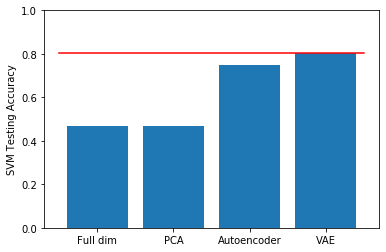

In [31]:
plt.figure()
plt.bar(
    ["Full dim", "PCA", "Autoencoder", "VAE"],
    [out_full, out_quick, out_ae_full, out_vae_full],
)
# plt.xticks(rotation='vertical')
plt.ylim(0, 1)
m = np.max([out_full, out_quick, out_ae_full, out_vae_full])
plt.plot((-0.5, 3.5), (m, m), c="red")
plt.ylabel("SVM Testing Accuracy")